In [2]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pycountry
import kagglehub
import zipfile
import os
import reverse_geocoder as rg
from PIL import Image
import random

## Dataset 1

In [2]:
ds1 = load_dataset("marcelomoreno26/geoguessr")

Generating test split: 100%|██████████| 5445/5445 [00:00<00:00, 13732.98 examples/s]


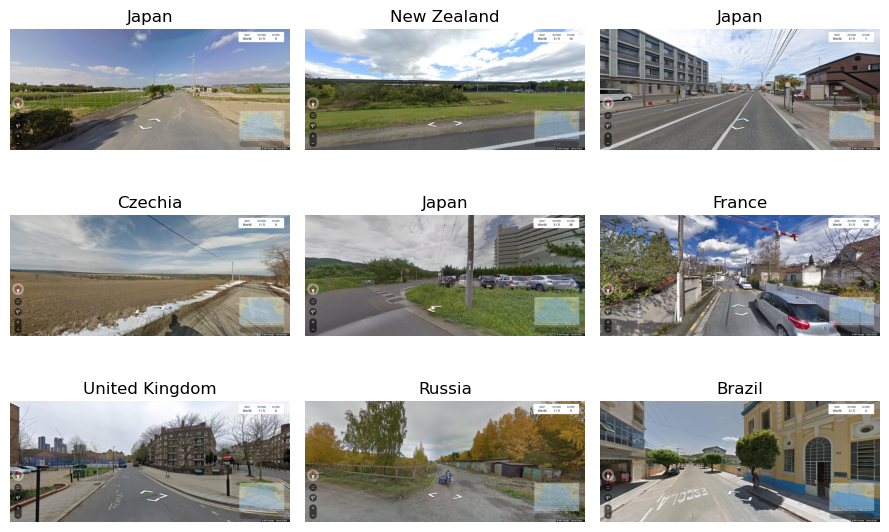

In [3]:
samples = ds1["train"].shuffle(seed=42).select(range(9))

# 3. Plot them in a 3×3 grid
plt.figure(figsize=(9,6))
for i, ex in enumerate(samples):
    img = ex["image"]
    ax = plt.subplot(3,3,i+1)
    ax.imshow(img); ax.axis("off")
    ax.set_title(ex["label"])
plt.tight_layout()
plt.show()

In [9]:
ds1

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 25160
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 5372
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 5445
    })
})

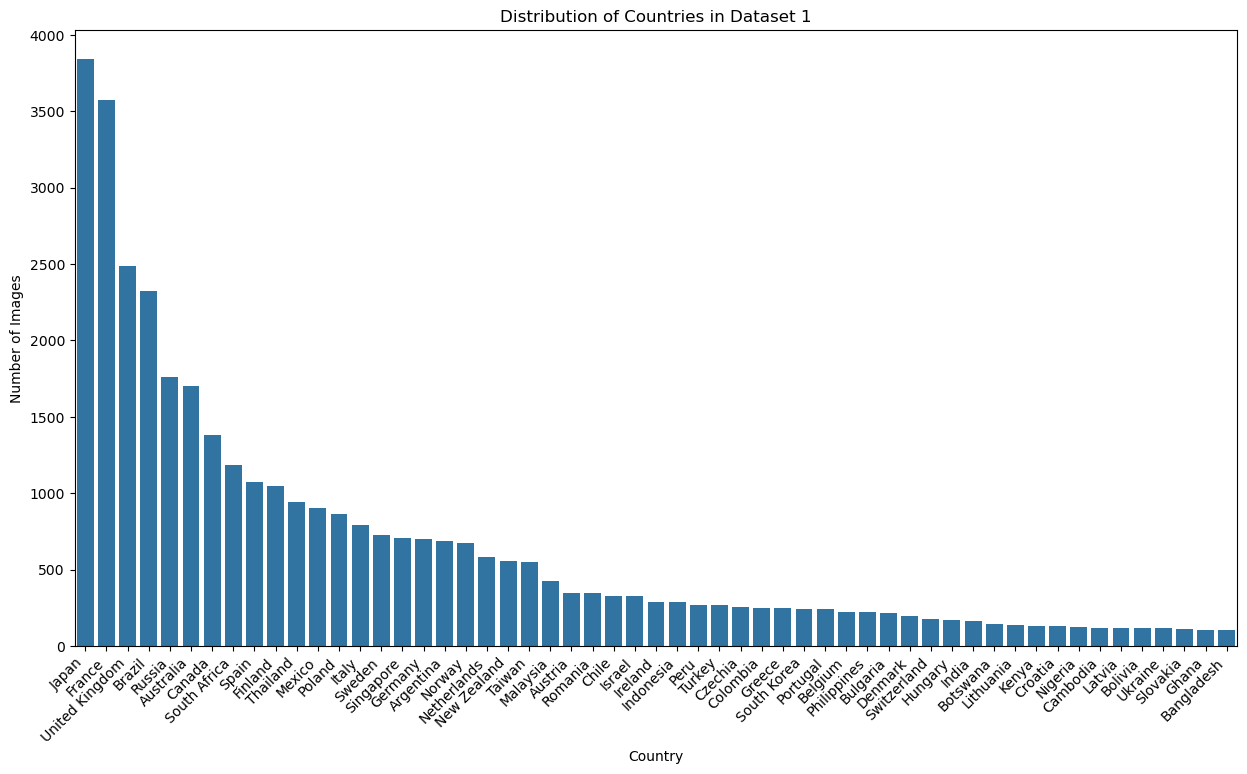

In [5]:
country_counts1 = Counter(ds1['train']['label'] + ds1['validation']['label'] + ds1['test']['label'])
country_counts1

# Create a bar plot in descending order
plt.figure(figsize=(15, 8))
sns.barplot(x=list(country_counts1.keys()), y=list(country_counts1.values()), order=sorted(country_counts1, key=lambda x: country_counts1[x], reverse=True))
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Countries in Dataset 1')
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.show()


## Dataset 2

In [10]:
ds2 = load_dataset("stochastic/random_streetview_images_pano_v0.0.2")

Generating train split: 100%|██████████| 11054/11054 [00:03<00:00, 3031.20 examples/s]


In [11]:
ds2

DatasetDict({
    train: Dataset({
        features: ['image', 'country_iso_alpha2', 'latitude', 'longitude', 'address'],
        num_rows: 11054
    })
})

In [32]:
def iso2_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return code

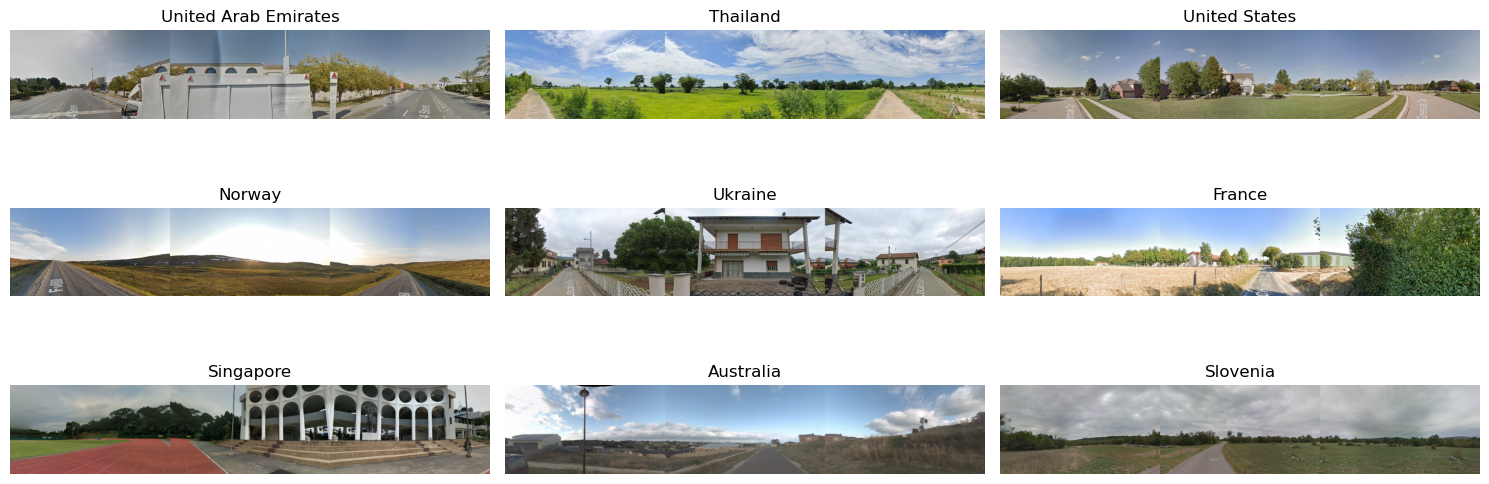

In [36]:
samples = ds2["train"].shuffle(seed=42).select(range(9))

# 3. Plot them in a 3×3 grid
plt.figure(figsize=(15,6))
for i, ex in enumerate(samples):
    img = ex["image"]
    ax = plt.subplot(3,3,i+1)
    ax.imshow(img); ax.axis("off")
    ax.set_title(iso2_to_name(ex["country_iso_alpha2"]))
plt.tight_layout()
plt.show()

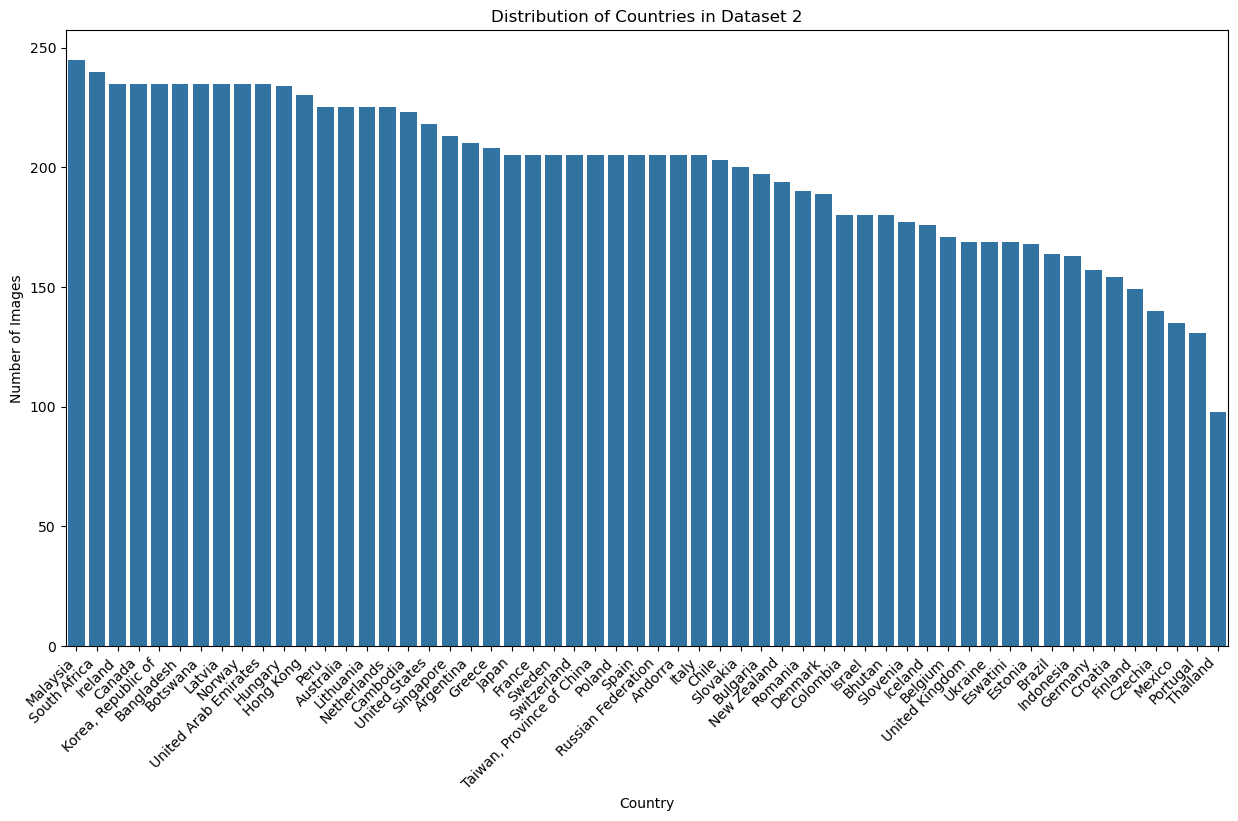

In [44]:
country_counts2 = Counter([iso2_to_name(code) for code in ds2['train']['country_iso_alpha2']])
country_counts2

# Create a bar plot in descending order
plt.figure(figsize=(15, 8))
sns.barplot(x=list((country_counts2.keys())), y=list(country_counts2.values()), order=sorted(country_counts2, key=lambda x: country_counts2[x], reverse=True))
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Countries in Dataset 2')
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.show()


## Merged

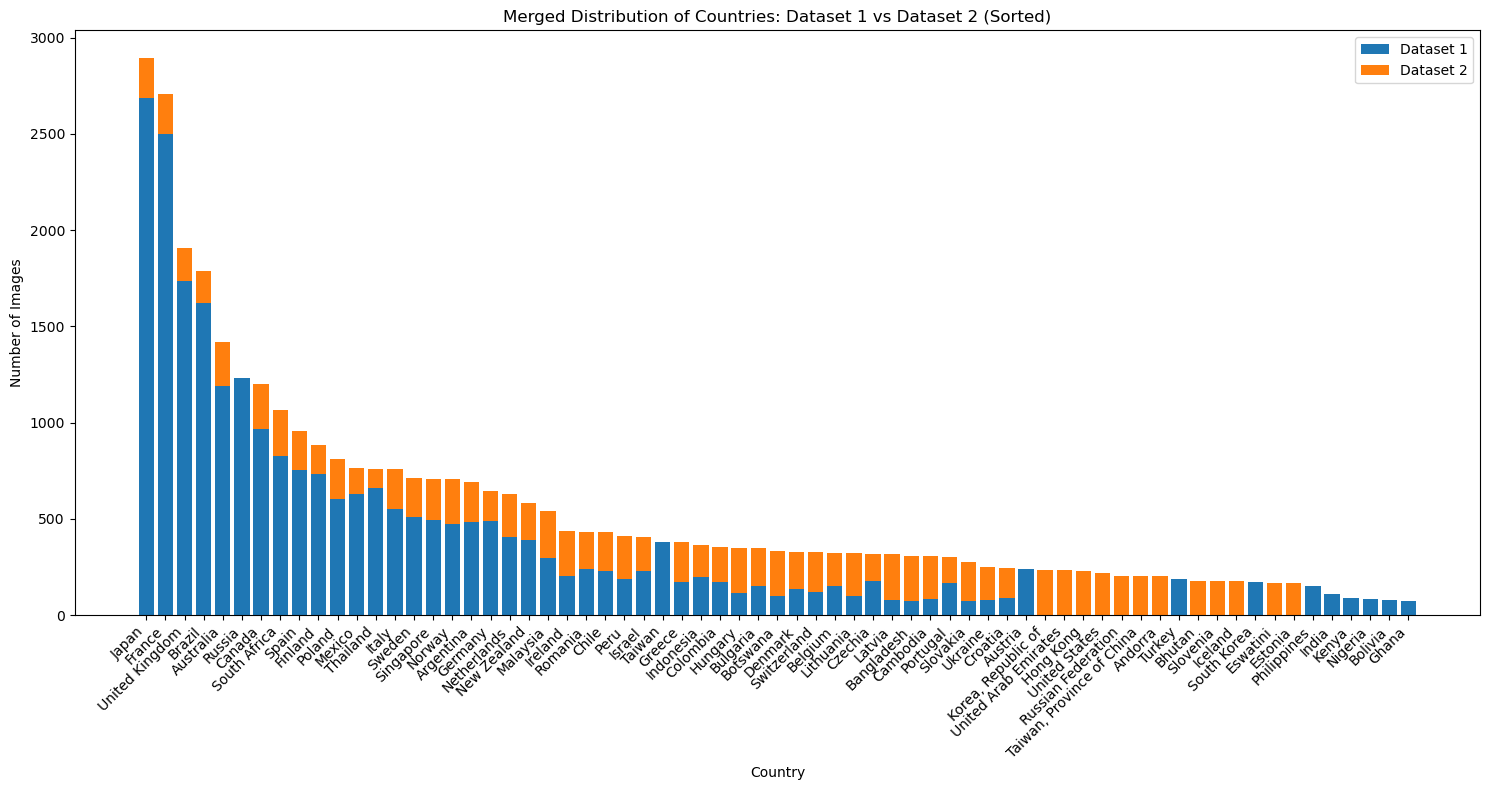

In [10]:
# Build a combined DataFrame
all_countries = sorted(set(country_counts1.keys()) | set(country_counts2.keys()))
data = {
    'Dataset 1': [country_counts1.get(c, 0) for c in all_countries],
    'Dataset 2': [country_counts2.get(c, 0) for c in all_countries]
}
df = pd.DataFrame(data, index=all_countries)
df['Total'] = df['Dataset 1'] + df['Dataset 2']

# Sort by total descending
df_sorted = df.sort_values(by='Total', ascending=False)

# Plot stacked bar chart
labels = df_sorted.index.tolist()
x = np.arange(len(labels))
ds1_vals = df_sorted['Dataset 1'].values
ds2_vals = df_sorted['Dataset 2'].values

plt.figure(figsize=(15, 8))
plt.bar(x, ds1_vals, label='Dataset 1', color='#1f77b4')
plt.bar(x, ds2_vals, bottom=ds1_vals, label='Dataset 2', color='#ff7f0e')
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.title('Merged Distribution of Countries: Dataset 1 vs Dataset 2 (Sorted)')
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

## Dataset 3

In [6]:
path = kagglehub.dataset_download("ubitquitin/geolocation-geoguessr-images-50k")

print("Path to dataset files:", path)

  0%|          | 16.0M/6.66G [00:02<17:22, 6.84MB/s]  


KeyboardInterrupt: 

In [7]:
def iso2_to_name(code):
    try:
        return pycountry.countries.get(alpha_2=code).name
    except:
        return code

In [ ]:
dataset_path = '/Users/michelangelonardi/.cache/kagglehub/datasets/ubitquitin/geolocation-geoguessr-images-50k/versions/1/compressed_dataset'

# ─── STEP 1: Count image files per country ─────────────────────────────────────
country_counts3 = {}
for country in os.listdir(dataset_path):
    country_dir = os.path.join(dataset_path, country)
    if os.path.isdir(country_dir):
        # count only image extensions
        imgs = [f for f in os.listdir(country_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        country_counts3[country] = len(imgs)

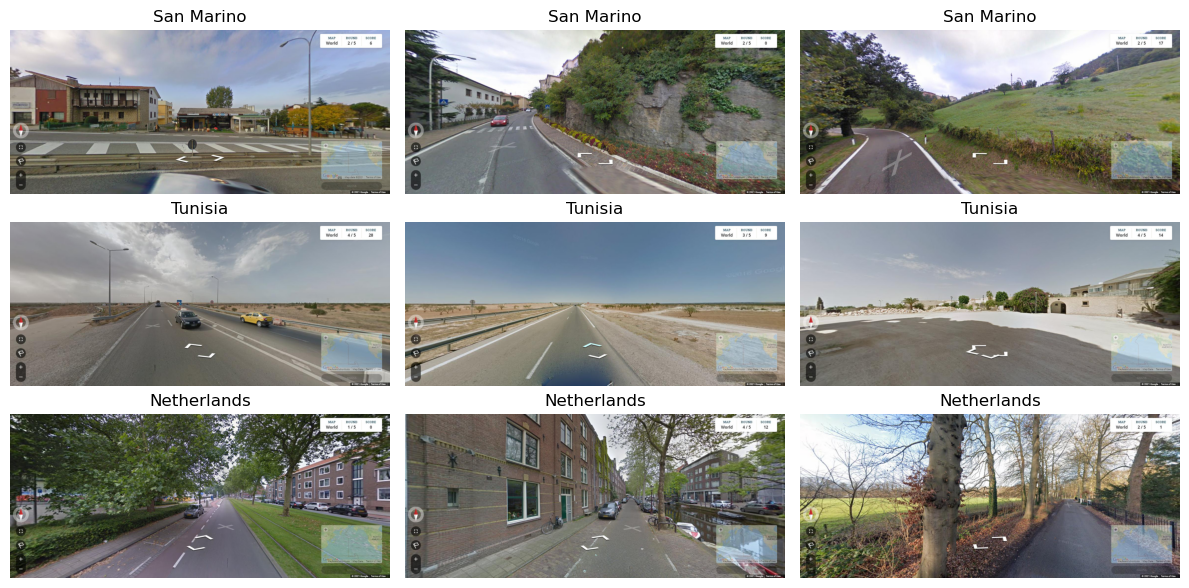

In [37]:
root = dataset_path

countries = os.listdir(root)
# pick 9 random images
choices = []
for country in random.sample(countries, 3):
    imgs = os.listdir(os.path.join(root, country))
    for fname in random.sample(imgs, 3):
        choices.append((country, os.path.join(root, country, fname)))

plt.figure(figsize=(12,6))
for i, (country, path) in enumerate(choices):
    img = Image.open(path).convert("RGB")
    ax = plt.subplot(3,3,i+1)
    ax.imshow(img); ax.axis("off")
    ax.set_title(country)
plt.tight_layout()
plt.show()

In [14]:
# ─── STEP 2: Build a DataFrame (keep only countries with more than 100 counts) and display ─────────────────────────────────────
df_counts3 = (
    pd.DataFrame.from_dict(country_counts3, orient='index', columns=['count'])
      .reset_index().rename(columns={'index':'country'})
      .sort_values('count', ascending=False)
      .query('count > 50')
)

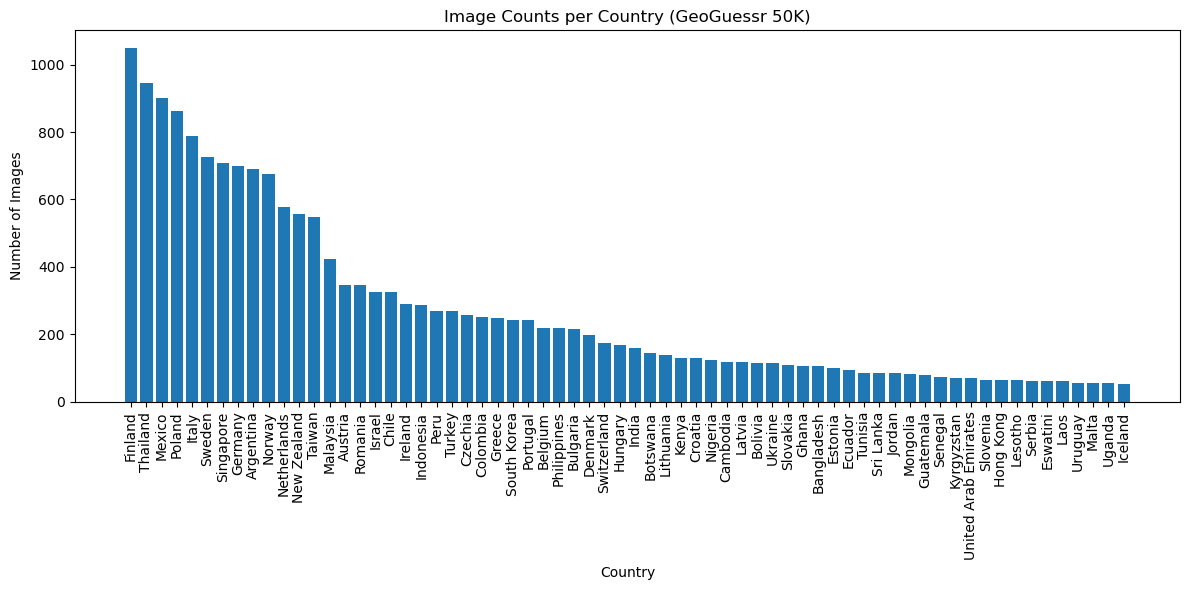

In [15]:
# ─── STEP 3: Plot a bar chart with Matplotlib ──────────────────────────────────
plt.figure(figsize=(12, 6))
plt.bar(df_counts3['country'][10:], df_counts3['count'][10:])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.title('Image Counts per Country (GeoGuessr 50K)')
plt.tight_layout()
plt.show()

## Merged

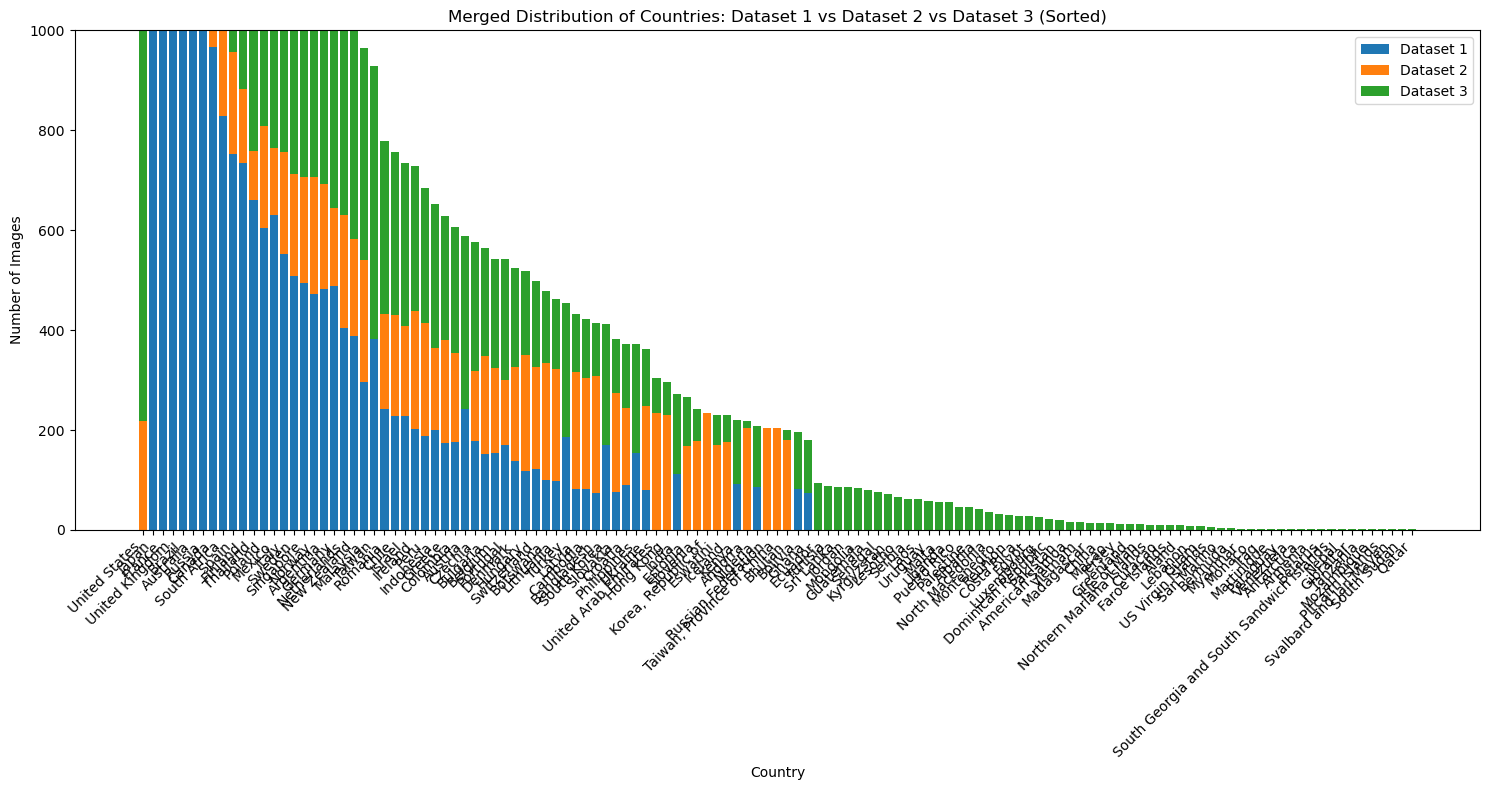

In [16]:
# Merge all country keys
all_countries = sorted(set(country_counts1.keys()) | set(country_counts2.keys()) | set(country_counts3.keys()))

# Build DataFrame
data = {
    'Dataset 1': [country_counts1.get(c, 0) for c in all_countries],
    'Dataset 2': [country_counts2.get(c, 0) for c in all_countries],
    'Dataset 3': [country_counts3.get(c, 0) for c in all_countries],
}
df = pd.DataFrame(data, index=all_countries)
df['Total'] = df.sum(axis=1)

# Sort by total descending
df_sorted = df.sort_values(by='Total', ascending=False)

# Prepare values
labels = df_sorted.index.tolist()
x = np.arange(len(labels))
ds1_vals = df_sorted['Dataset 1'].values
ds2_vals = df_sorted['Dataset 2'].values
ds3_vals = df_sorted['Dataset 3'].values

# Plot stacked bar chart with three colors
plt.figure(figsize=(15, 8))
plt.bar(x, ds1_vals, label='Dataset 1', color='#1f77b4')
plt.bar(x, ds2_vals, bottom=ds1_vals, label='Dataset 2', color='#ff7f0e')
plt.bar(x, ds3_vals, bottom=ds1_vals+ds2_vals, label='Dataset 3', color='#2ca02c')
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.title('Merged Distribution of Countries: Dataset 1 vs Dataset 2 vs Dataset 3 (Sorted)')
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.ylim(0, 1000)

plt.tight_layout()
plt.show()

### Filtered 

In [52]:
# filter to only consider these countries 
COUNTRIES = ["Albania","Andorra","Argentina","Australia","Austria","Bangladesh","Belgium","Bhutan","Bolivia","Botswana","Brazil","Bulgaria","Cambodia","Canada","Chile","Colombia","Croatia","Czechia","Denmark","Dominican Republic","Ecuador","Estonia","Eswatini","Finland","France","Germany","Ghana","Greece","Greenland","Guatemala","Hungary","Iceland","Indonesia","Ireland","Israel","Italy","Japan","Jordan","Kenya","Kyrgyzstan","Latvia","Lesotho","Lithuania","Luxembourg","Malaysia","Mexico","Mongolia","Montenegro","Netherlands","New Zealand","Nigeria","North Macedonia","North Mariana Islands","Norway","Palestine","Panama","Peru","Philippines","Poland","Portugal","Romania","Russia","Senegal","Serbia","Singapore","Slovakia","Slovenia","South Africa","South Korea","Spain","Sri Lanka","Sweden","Switzerland","Taiwan","Thailand","Turkey","Ukraine","United Arab Emirates","United Kingdom","United States","Uruguay"]
len(COUNTRIES)

81

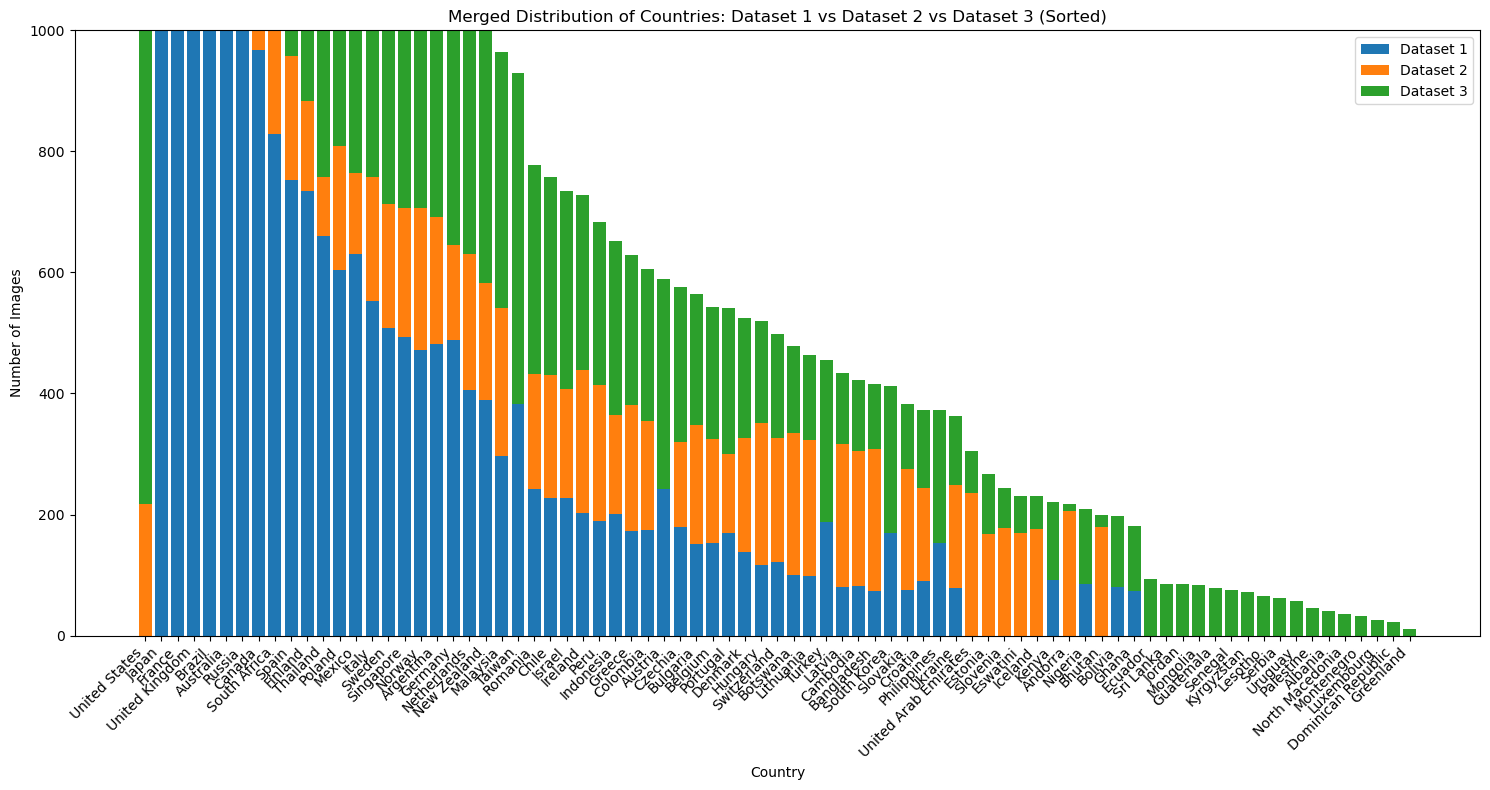

In [20]:
filtered_df = df[df.index.isin(COUNTRIES)]

# Sort by total descending
filtered_df_sorted = filtered_df.sort_values(by='Total', ascending=False)

# Prepare values
labels = filtered_df_sorted.index.tolist()
x = np.arange(len(labels))
ds1_vals = filtered_df_sorted['Dataset 1'].values
ds2_vals = filtered_df_sorted['Dataset 2'].values
ds3_vals = filtered_df_sorted['Dataset 3'].values

# Plot stacked bar chart with three colors
plt.figure(figsize=(15, 8))
plt.bar(x, ds1_vals, label='Dataset 1', color='#1f77b4')
plt.bar(x, ds2_vals, bottom=ds1_vals, label='Dataset 2', color='#ff7f0e')
plt.bar(x, ds3_vals, bottom=ds1_vals+ds2_vals, label='Dataset 3', color='#2ca02c')
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.title('Merged Distribution of Countries: Dataset 1 vs Dataset 2 vs Dataset 3 (Sorted)')
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.ylim(0, 1000)

plt.tight_layout()
plt.show()


## Dataset 4

In [29]:
# Download latest version
path = kagglehub.dataset_download("paulchambaz/google-street-view")

print("Path to dataset files:", path)

100%|██████████| 600M/600M [00:42<00:00, 14.7MB/s] 

Extracting model files...


Path to dataset files: /Users/michelangelonardi/.cache/kagglehub/datasets/paulchambaz/google-street-view/versions/1


In [ ]:
dataset_path4 = "/Users/michelangelonardi/.cache/kagglehub/datasets/paulchambaz/google-street-view/versions/1/dataset"

# open csv file
with open(os.path.join(dataset_path4, 'coords.csv'), 'r') as f:
    lines = f.readlines()


In [ ]:
root = dataset_path4

# List all PNG files in that directory
all_imgs = [f for f in os.listdir(root) if f.lower().endswith('.png')]

# Pick 9 at random (or fewer if you have <9 images)
selection = random.sample(all_imgs, min(9, len(all_imgs)))

# Plot them
plt.figure(figsize=(9, 9))
for i, fname in enumerate(selection):
    img_path = os.path.join(root, fname)
    img = Image.open(img_path).convert("RGB")
    
    ax = plt.subplot(3, 3, i + 1)
    ax.imshow(img)
    ax.axis("off")
    
    # Use the filename (minus extension) as title
    title = os.path.splitext(fname)[0]
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [46]:
coords = []
for line in lines:
    lat_str, lon_str = line.strip().split(',')
    coords.append((float(lat_str), float(lon_str)))

In [47]:
results = rg.search(coords, mode=1)  

Loading formatted geocoded file...


In [48]:
country_names = []
for res in results:
    iso_cc = res['cc']                   # e.g. 'MX', 'BR', 'AU', …
    country = pycountry.countries.get(alpha_2=iso_cc)
    country_names.append(country.name if country else iso_cc)

In [49]:
country_counts4 = Counter(country_names)

## Merged (and accounted for multiplication factor)

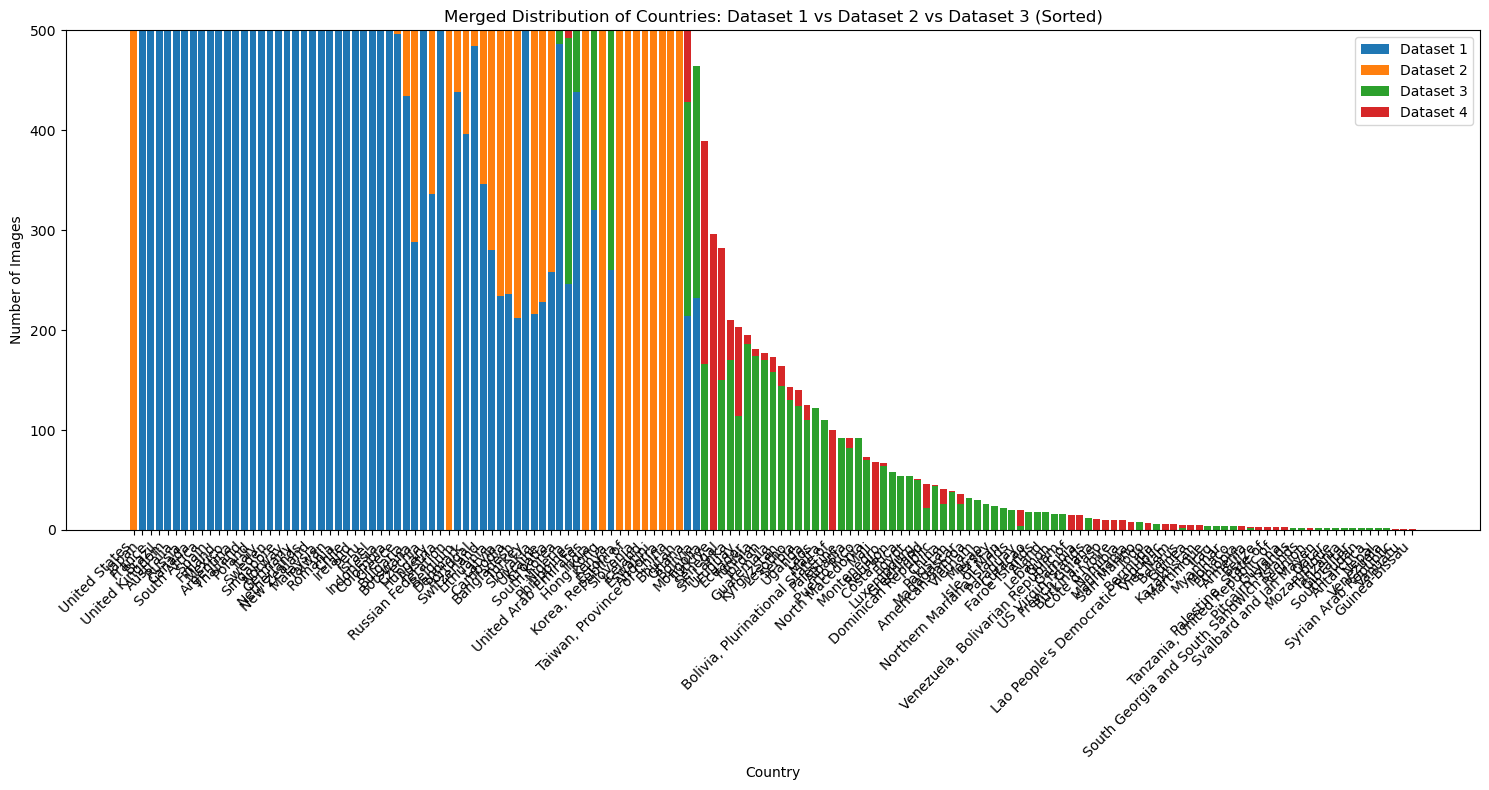

In [50]:
# Merge all country keys
all_countries = sorted(set(country_counts1.keys()) | set(country_counts2.keys()) | set(country_counts3.keys()) | set(country_counts4.keys()))

# Build DataFrame
data = {
    'Dataset 1': [country_counts1.get(c, 0) * 2 for c in all_countries],
    'Dataset 2': [country_counts2.get(c, 0) * 3 for c in all_countries],
    'Dataset 3': [country_counts3.get(c, 0) * 2 for c in all_countries],
    'Dataset 4': [country_counts4.get(c, 0) for c in all_countries],
}
df = pd.DataFrame(data, index=all_countries)
df['Total'] = df.sum(axis=1)

# Sort by total descending
df_sorted = df.sort_values(by='Total', ascending=False)

# Prepare values
labels = df_sorted.index.tolist()
x = np.arange(len(labels))
ds1_vals = df_sorted['Dataset 1'].values
ds2_vals = df_sorted['Dataset 2'].values
ds3_vals = df_sorted['Dataset 3'].values
ds4_vals = df_sorted['Dataset 4'].values

# Plot stacked bar chart with three colors
plt.figure(figsize=(15, 8))
plt.bar(x, ds1_vals, label='Dataset 1', color='#1f77b4')
plt.bar(x, ds2_vals, bottom=ds1_vals, label='Dataset 2', color='#ff7f0e')
plt.bar(x, ds3_vals, bottom=ds1_vals+ds2_vals, label='Dataset 3', color='#2ca02c')
plt.bar(x, ds4_vals, bottom=ds1_vals+ds2_vals+ds3_vals, label='Dataset 4', color='#d62728')
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.title('Merged Distribution of Countries: Dataset 1 vs Dataset 2 vs Dataset 3 (Sorted)')
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.ylim(0, 500)

plt.tight_layout()
plt.show()

### Filtered (to our 81 geoguesser countries)

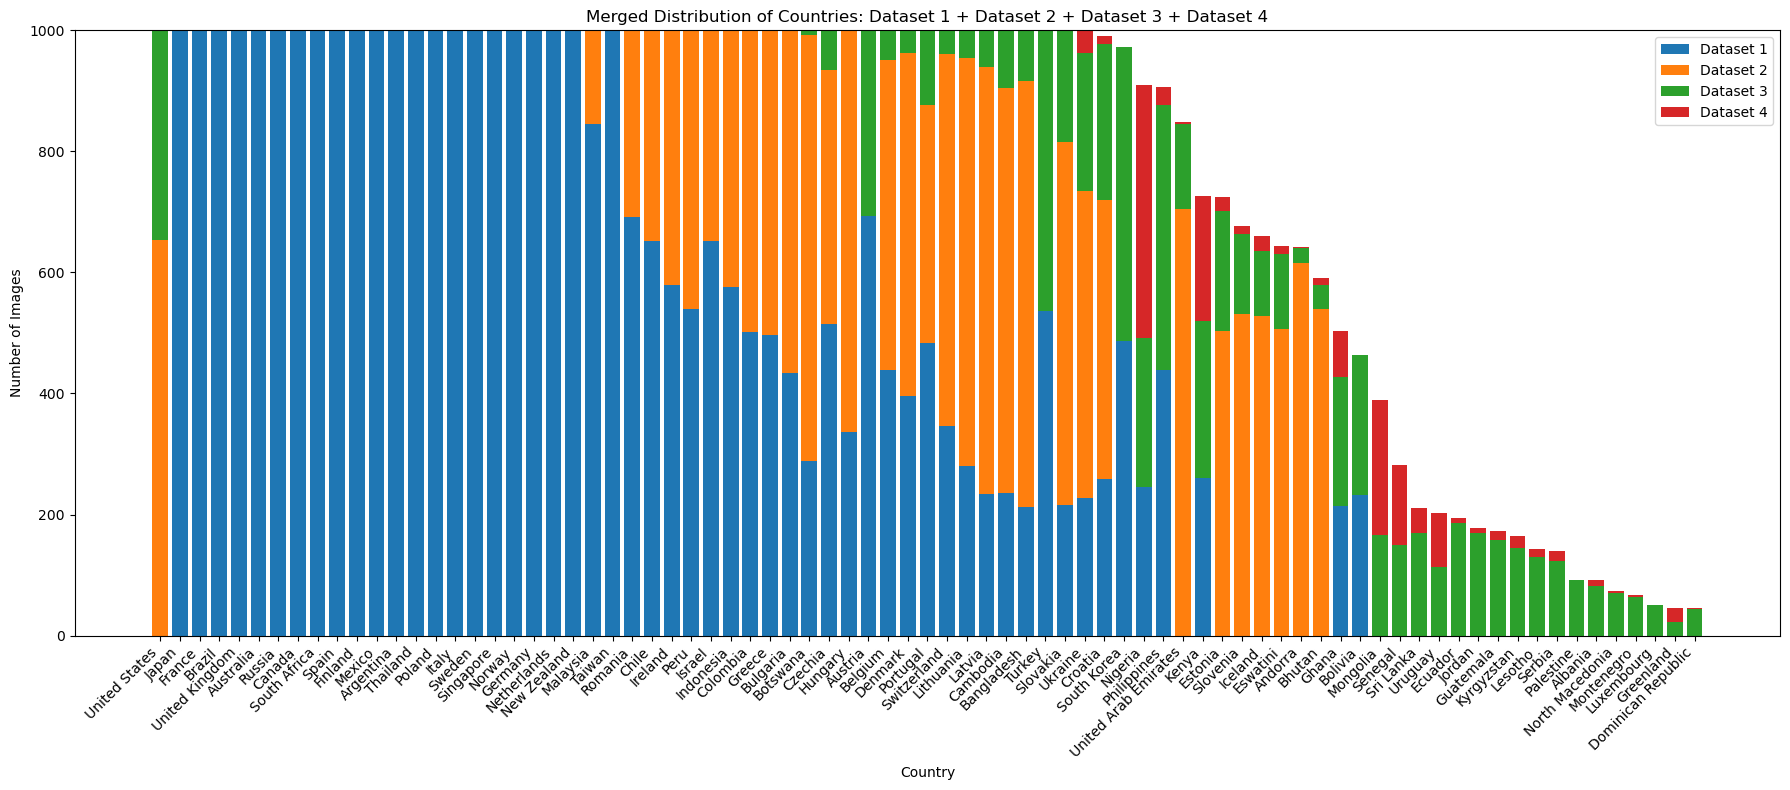

In [53]:
filtered_df = df[df.index.isin(COUNTRIES)]

# Sort by total descending
filtered_df_sorted = filtered_df.sort_values(by='Total', ascending=False)

# Prepare values
labels = filtered_df_sorted.index.tolist()
x = np.arange(len(labels))
ds1_vals = filtered_df_sorted['Dataset 1'].values
ds2_vals = filtered_df_sorted['Dataset 2'].values 
ds3_vals = filtered_df_sorted['Dataset 3'].values
ds4_vals = filtered_df_sorted['Dataset 4'].values

# Plot stacked bar chart with three colors
plt.figure(figsize=(18, 8))
plt.bar(x, ds1_vals, label='Dataset 1', color='#1f77b4')
plt.bar(x, ds2_vals, bottom=ds1_vals, label='Dataset 2', color='#ff7f0e')
plt.bar(x, ds3_vals, bottom=ds1_vals+ds2_vals, label='Dataset 3', color='#2ca02c')
plt.bar(x, ds4_vals, bottom=ds1_vals+ds2_vals+ds3_vals, label='Dataset 4', color='#d62728')
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.title('Merged Distribution of Countries: Dataset 1 + Dataset 2 + Dataset 3 + Dataset 4')
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.ylim(0, 1000)

plt.tight_layout()
plt.show()


In [54]:
# Calculate how many images each country is short of 500
shortfall = 500 - filtered_df_sorted['Total']

# Keep only those with a positive shortfall
missing_to_500 = shortfall[shortfall > 0].sort_values(ascending=False)

missing_to_500

Dominican Republic    455
Greenland             454
Luxembourg            449
Montenegro            433
North Macedonia       427
Albania               408
Palestine             408
Serbia                360
Lesotho               357
Kyrgyzstan            336
Guatemala             327
Jordan                323
Ecuador               305
Uruguay               297
Sri Lanka             290
Senegal               218
Mongolia              111
Bolivia                36
Name: Total, dtype: int64

In [56]:
df_missing = (
    missing_to_500
      .reset_index()
      .rename(columns={'index':'country', 0:'missing_images'})
)
# missing_to_500 is a Series, so rename its value column
df_missing.columns = ['country','missing_images']

# Show it sorted by who’s missing the most
df_missing

country  missing_images
0   Dominican Republic             455
1            Greenland             454
2           Luxembourg             449
3           Montenegro             433
4      North Macedonia             427
5              Albania             408
6            Palestine             408
7               Serbia             360
8              Lesotho             357
9           Kyrgyzstan             336
10           Guatemala             327
11              Jordan             323
12             Ecuador             305
13             Uruguay             297
14           Sri Lanka             290
15             Senegal             218
16            Mongolia             111
17             Bolivia              36

In [57]:
list(df_missing['country'])

['Dominican Republic',
 'Greenland',
 'Luxembourg',
 'Montenegro',
 'North Macedonia',
 'Albania',
 'Palestine',
 'Serbia',
 'Lesotho',
 'Kyrgyzstan',
 'Guatemala',
 'Jordan',
 'Ecuador',
 'Uruguay',
 'Sri Lanka',
 'Senegal',
 'Mongolia',
 'Bolivia']

## Additional images 

In [58]:
# count the number of images per country/folder in "additional_images" folder
additional_images_path = "additional_images"
additional_images_counts = {}
for country in os.listdir(additional_images_path):
    country_dir = os.path.join(additional_images_path, country)
    if os.path.isdir(country_dir):
        # count only image extensions
        imgs = [f for f in os.listdir(country_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        additional_images_counts[country] = len(imgs)
additional_images_counts

{'Luxembourg': 502,
 'Kyrgyzstan': 502,
 'Ghana': 500,
 'Ecuador': 502,
 'Guatemala': 502,
 'Dominican_Republic': 502,
 'Montenegro': 502,
 'Serbia': 502,
 'Lesotho': 502,
 'Sri_Lanka': 503,
 'Albania': 503,
 'Mongolia': 502,
 'Uruguay': 504,
 'Senegal': 502,
 'Bolivia': 500,
 'North_Macedonia': 502,
 'Palestine': 485,
 'Greenland': 502,
 'Jordan': 503}

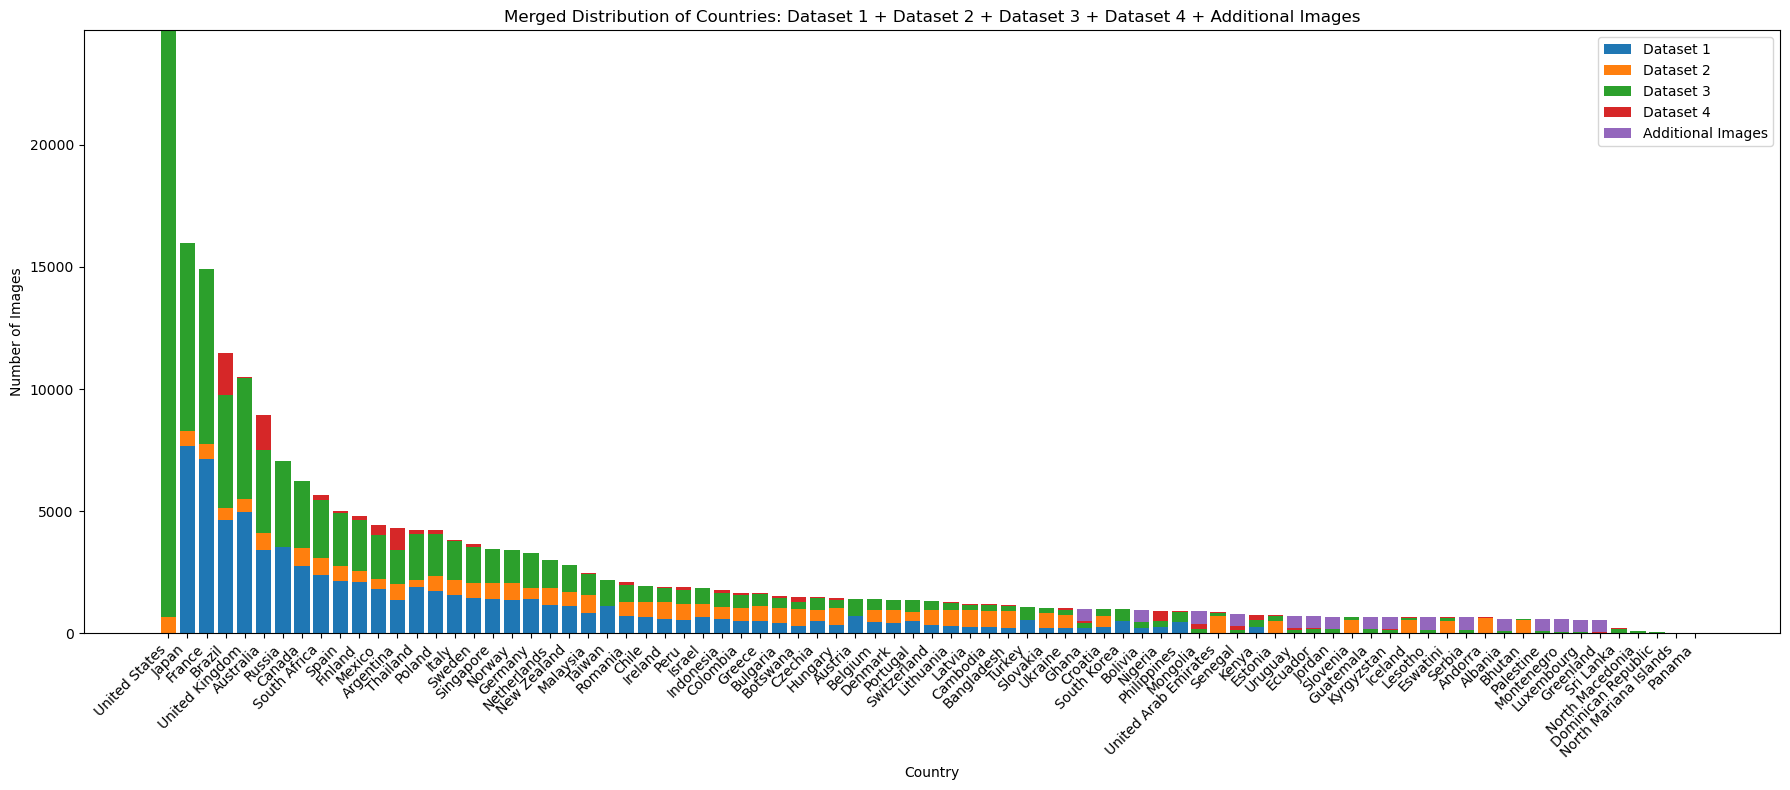

In [71]:
# Merge all country keys
all_countries = sorted(set(country_counts1.keys()) | set(country_counts2.keys()) | set(country_counts3.keys()) | set(country_counts4.keys()) | set(additional_images_counts.keys()))
all_countries = ["Albania","Andorra","Argentina","Australia","Austria","Bangladesh","Belgium","Bhutan","Bolivia","Botswana","Brazil","Bulgaria","Cambodia","Canada","Chile","Colombia","Croatia","Czechia","Denmark","Dominican Republic","Ecuador","Estonia","Eswatini","Finland","France","Germany","Ghana","Greece","Greenland","Guatemala","Hungary","Iceland","Indonesia","Ireland","Israel","Italy","Japan","Jordan","Kenya","Kyrgyzstan","Latvia","Lesotho","Lithuania","Luxembourg","Malaysia","Mexico","Mongolia","Montenegro","Netherlands","New Zealand","Nigeria","North Macedonia","North Mariana Islands","Norway","Palestine","Panama","Peru","Philippines","Poland","Portugal","Romania","Russia","Senegal","Serbia","Singapore","Slovakia","Slovenia","South Africa","South Korea","Spain","Sri Lanka","Sweden","Switzerland","Taiwan","Thailand","Turkey","Ukraine","United Arab Emirates","United Kingdom","United States","Uruguay"]

# filter to only consider these countries
#filtered_df = df[df.index.isin(COUNTRIES)]

# Build DataFrame
data = {
    'Dataset 1': [country_counts1.get(c, 0) * 2 for c in all_countries],
    'Dataset 2': [country_counts2.get(c, 0) * 3 for c in all_countries],
    'Dataset 3': [country_counts3.get(c, 0) * 2 for c in all_countries],
    'Dataset 4': [country_counts4.get(c, 0) for c in all_countries],
    'Additional Images': [additional_images_counts.get(c, 0) for c in all_countries],
}
df = pd.DataFrame(data, index=all_countries)
df['Total'] = df.sum(axis=1)
# Sort by total descending
df_sorted = df.sort_values(by='Total', ascending=False)
# Prepare values
labels = df_sorted.index.tolist()
x = np.arange(len(labels))
ds1_vals = df_sorted['Dataset 1'].values
ds2_vals = df_sorted['Dataset 2'].values
ds3_vals = df_sorted['Dataset 3'].values
ds4_vals = df_sorted['Dataset 4'].values
ds5_vals = df_sorted['Additional Images'].values

# Plot stacked bar chart with three colors
plt.figure(figsize=(18, 8))
plt.bar(x, ds1_vals, label='Dataset 1', color='#1f77b4')
plt.bar(x, ds2_vals, bottom=ds1_vals, label='Dataset 2', color='#ff7f0e')
plt.bar(x, ds3_vals, bottom=ds1_vals+ds2_vals, label='Dataset 3', color='#2ca02c')
plt.bar(x, ds4_vals, bottom=ds1_vals+ds2_vals+ds3_vals, label='Dataset 4', color='#d62728')
plt.bar(x, ds5_vals, bottom=ds1_vals+ds2_vals+ds3_vals+ds4_vals, label='Additional Images', color='#9467bd')
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.title('Merged Distribution of Countries: Dataset 1 + Dataset 2 + Dataset 3 + Dataset 4 + Additional Images')
plt.xlabel('Country')
plt.ylabel('Number of Images')
#plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [ ]:
# Merge all country keys
all_countries = sorted(set(country_counts1.keys()) | set(country_counts2.keys()) | set(country_counts3.keys()) | set(country_counts4.keys()) | set(additional_images_counts.keys()))
all_countries = ["Albania","Andorra","Argentina","Australia","Austria","Bangladesh","Belgium","Bhutan","Bolivia","Botswana","Brazil","Bulgaria","Cambodia","Canada","Chile","Colombia","Croatia","Czechia","Denmark","Dominican Republic","Ecuador","Estonia","Eswatini","Finland","France","Germany","Ghana","Greece","Greenland","Guatemala","Hungary","Iceland","Indonesia","Ireland","Israel","Italy","Japan","Jordan","Kenya","Kyrgyzstan","Latvia","Lesotho","Lithuania","Luxembourg","Malaysia","Mexico","Mongolia","Montenegro","Netherlands","New Zealand","Nigeria","North Macedonia","North Mariana Islands","Norway","Palestine","Panama","Peru","Philippines","Poland","Portugal","Romania","Russia","Senegal","Serbia","Singapore","Slovakia","Slovenia","South Africa","South Korea","Spain","Sri Lanka","Sweden","Switzerland","Taiwan","Thailand","Turkey","Ukraine","United Arab Emirates","United Kingdom","United States","Uruguay"]

# filter to only consider these countries
#filtered_df = df[df.index.isin(COUNTRIES)]

# Build DataFrame
data = {
    'Dataset 1': [country_counts1.get(c, 0) * 2 for c in all_countries],
    'Dataset 2': [country_counts2.get(c, 0) * 3 for c in all_countries],
    'Dataset 3': [country_counts3.get(c, 0) * 2 for c in all_countries],
    'Dataset 4': [country_counts4.get(c, 0) for c in all_countries],
    'Additional Images': [additional_images_counts.get(c, 0) for c in all_countries],
}
df = pd.DataFrame(data, index=all_countries)
df['Total'] = df.sum(axis=1)
# Sort by total descending
df_sorted = df.sort_values(by='Total', ascending=False)
# Prepare values
labels = df_sorted.index.tolist()
x = np.arange(len(labels))
ds1_vals = df_sorted['Dataset 1'].values
ds2_vals = df_sorted['Dataset 2'].values
ds3_vals = df_sorted['Dataset 3'].values
ds4_vals = df_sorted['Dataset 4'].values
ds5_vals = df_sorted['Additional Images'].values

# Plot stacked bar chart with three colors
plt.figure(figsize=(18, 8))
plt.bar(x, ds1_vals, label='Dataset 1', color='#1f77b4')
plt.bar(x, ds2_vals, bottom=ds1_vals, label='Dataset 2', color='#ff7f0e')
plt.bar(x, ds3_vals, bottom=ds1_vals+ds2_vals, label='Dataset 3', color='#2ca02c')
plt.bar(x, ds4_vals, bottom=ds1_vals+ds2_vals+ds3_vals, label='Dataset 4', color='#d62728')
plt.bar(x, ds5_vals, bottom=ds1_vals+ds2_vals+ds3_vals+ds4_vals, label='Additional Images', color='#9467bd')
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.title('Merged Distribution of Countries: Dataset 1 + Dataset 2 + Dataset 3 + Dataset 4 + Additional Images')
plt.xlabel('Country')
plt.ylabel('Number of Images')
plt.ylim(0, 100)

plt.tight_layout()
plt.show()